In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from random import seed, randint
import spectral
"""
This script works on labels of sugarcane images. Given a binary image label which is the same spatial size 
as the original hyperspectral image. In this label, 0 indicates background pixels, while 1 indicates sugarcane 
pixel. The goal is to crop such hyperspectral image into multiple 32x32 patches, we will apply a sliding window 
approach to slide through the image without overlap. However, not all the image patches will be saved, as most of 
them contain 0 to less than 20% of sugarcane pixel. 

So the purpose of this script is to generate coordinates of qualified image patches for every image, these 
coordinates will be saved in a txt file. To determine if an image patch is qualified, we need to see if the 
percentage of sugarcane pixels surpass the predefined threshold. To see if a pixel is sugarcane pixel or background, 
we need to use label image in this case. 

"""
IMG_PATH="E:\Sugarcane_Dataset_Label\Apr22" # Path of the subdataset label folder
COORDINATE_TXT_FILE_NAME="Apr22_coordinates.txt"
HEIGHT=1088
WIDTH=2048
TOTAL_PIXELS=1024# total pixels in an image patch
WINDOW_SIZE=32 # the size of image patches
THRESHOLD=0.45# predefined threshold, for different subdataset, a different threshold will be used, check readme document.
TARGET_FOLDERS=["CP29-116","CP29-116_c","Nco310","Nco310_c","Q44","Q44_c","Q68",
             "Q68_c","Q78","Q78_c","Q82","Q82_c","Q124","Q124_c","Q171","Q171_c",
             "Q205","Q205_c","Q208","Q208_c"]

In [2]:
class SugarcaneImage:# every sugarcane image has its path and a list of coordinates of the qulified image patches. 
    def __init__(self, img_path):
        self.img_path=img_path # Image path
        self.coordinate_list=[] # patch coordinates of the image

In [3]:
def get_img_path_list():
    """
    Get all the image path in the target foler.
    Args:
        None.
    Returns:
        img_path_list: list of string, all the image paths inside.
    """
    img_path_list=[]
    count=0
    a=0
    for (root, dirs, files) in os.walk(IMG_PATH, topdown=True):
        if count>0:
            if root.split("/")[-1] in TARGET_FOLDERS:
                files.sort()
                for index, filename in enumerate(files):
                    if filename.endswith('.png'):
                        img_path_list.append(root.split("/")[-1]+'/'+filename)
        count+=1
    return img_path_list

def generate_coordinate():
    """
    Generate the patch coodrinates
    Args:
        None.
    Returns:
        coordinate_list: list of tuple, all the top-left corner coordinate of patch inside.
    """
    coordinate_list=[]
    for i in range(0,1088,WINDOW_SIZE):
        for j in range(0, 2048,WINDOW_SIZE):
            coordinate_list.append((i,j))
    return coordinate_list

def compute_percentage(m):
    """
    Compute the sugarcane pixel percentage in a patch
    Args:
        m: array, binary map, 1 represent sugarcane pixel, 0 represents background pixel.
    Returns:
        the percentage.
    """
    num_of_sugarcane_pixels=np.sum(m)
    return num_of_sugarcane_pixels/TOTAL_PIXELS

def remove_unqualified_patches(label_img, coordinate_list):
    """
    Remove the patch if the sugarcane pixels don't occupy a percentage that is greater 
    than the threshold.
    Args:
        label_img: array, binary map, label image, 1 represent sugarcane pixel, 0 represents background pixel.
        coordinate_list: list of tuple, coordinates of all the image patches in an image.
    Returns:
        new_coordinate_list: list of tuple, coordinates of qualified image patches.
    """
    new_coordinate_list=[]
    for t in coordinate_list:
        patch=label_img[t[0]:t[0]+WINDOW_SIZE,t[1]:t[1]+WINDOW_SIZE]
        #if np.unique(patch).shape[0]==2:# this line caused a bug before, patches with 100% sugarcane pixels got unqualified.
        percentage=compute_percentage(patch)
        if percentage>THRESHOLD: #Threshold to be set, depends on the dataset. 
            new_coordinate_list.append(t)
    return new_coordinate_list

def sugarcane_list(img_path_list, coordinate_list):
    """
    Get the list of SugarcaneImage
    Args:
        None.
    Returns:
        sugarcane_img_list: list of SugarcaneImage.
    """
    os.chdir(IMG_PATH)# navigate to subdataset folder
    sugarcane_img_list=[]
    for path in img_path_list:
        label_img=np.array(Image.open(path)).astype(np.int32)[:,:,0]
        label_img[label_img>1]=1 # Convert the matrix to binary matrix.
        new_coordinate_list=remove_unqualified_patches(label_img, coordinate_list)
        sugarcane=SugarcaneImage(path)
        if len(path.split("/")[0].split("_"))==1: # Infected 
            sugarcane.state=1
        else: # Healthy 
            sugarcane.state=0
        sugarcane.coordinate_list=new_coordinate_list
        sugarcane_img_list.append(sugarcane)
    return sugarcane_img_list

def save_data(sugarcane_img_list):
    """
    Save the coordinate txt file for each image.
    Args:
        sugarcane_img_list: list of SugarcaneImage.
    Returns:
        None.
    """
    os.chdir(IMG_PATH)
    #EXTERNAL_PATH="/media/deep/Backup Plus/Dataset/Apr22/"
    f=open(COORDINATE_TXT_FILE_NAME,'w')
    for sugarcane in sugarcane_img_list:
        coordinate_str=""
        for t in sugarcane.coordinate_list:
            coordinate_str+=str(t[0])+" "+str(t[1])+"*"
        coordinate_str=coordinate_str[0:-1]# remove the last "*"
        item=sugarcane.img_path.split(".")[0]+".hdr+"+coordinate_str+"\n"
        f.write(item)
    f.close()

In [4]:
img_path_list=get_img_path_list()
print(len(img_path_list))# total number of images in this subdataset folder.

100


In [6]:
coordinate_list=generate_coordinate()
print(len(coordinate_list))#(1088/32)*(2048/32)=2176 image patches in a given hyperspectral image.

2176


In [10]:
count_p=0
count_n=0
sugarcane_img_list=sugarcane_list(img_path_list, coordinate_list)
for sugarcane in sugarcane_img_list:# check the number of qulified image patched of every image.
    print(sugarcane.img_path, len(sugarcane.coordinate_list))
    if sugarcane.state==1:
        count_p+=len(sugarcane.coordinate_list)
    else:
        count_n+=len(sugarcane.coordinate_list)
print(count_p,count_n)

Nco310/Nco310_10_normalized.png 166
Nco310/Nco310_1_normalized.png 21
Nco310/Nco310_2_normalized.png 141
Nco310/Nco310_3_normalized.png 96
Nco310/Nco310_4_normalized.png 158
Nco310/Nco310_5_normalized.png 203
Nco310/Nco310_6_normalized.png 99
Nco310/Nco310_7_normalized.png 156
Nco310/Nco310_8_normalized.png 89
Nco310/Nco310_9_normalized.png 122
Q171/Q171_10_normalized.png 7
Q171/Q171_1_normalized.png 79
Q171/Q171_2_normalized.png 170
Q171/Q171_3_normalized.png 112
Q171/Q171_4_normalized.png 44
Q171/Q171_5_normalized.png 85
Q171/Q171_6_normalized.png 119
Q171/Q171_7_normalized.png 89
Q171/Q171_8_normalized.png 30
Q171/Q171_9_normalized.png 47
Q124/Q124_10_normalized.png 70
Q124/Q124_1_normalized.png 314
Q124/Q124_2_normalized.png 208
Q124/Q124_3_normalized.png 175
Q124/Q124_4_normalized.png 234
Q124/Q124_5_normalized.png 211
Q124/Q124_6_normalized.png 203
Q124/Q124_7_normalized.png 198
Q124/Q124_8_normalized.png 213
Q124/Q124_9_normalized.png 244
Q171_c/Q171_10_c_normalized.png 173
Q171

Nco310/Nco310_10_normalized.png


<ipython-input-16-08864ee34803>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Nco310/Nco310_1_normalized.png
Nco310/Nco310_2_normalized.png
Nco310/Nco310_3_normalized.png
Nco310/Nco310_4_normalized.png
Nco310/Nco310_5_normalized.png
Nco310/Nco310_6_normalized.png
Nco310/Nco310_7_normalized.png
Nco310/Nco310_8_normalized.png
Nco310/Nco310_9_normalized.png


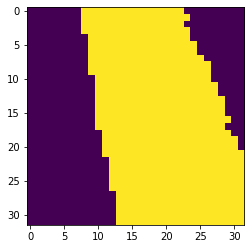

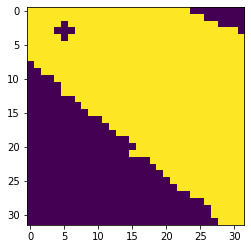

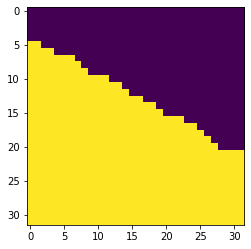

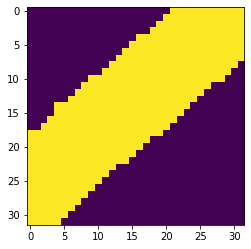

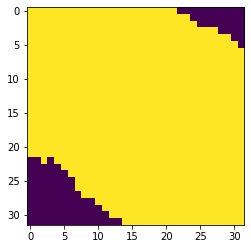

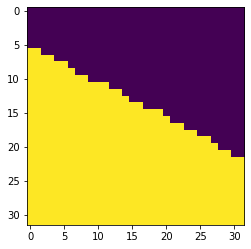

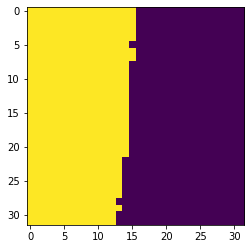

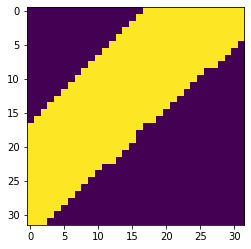

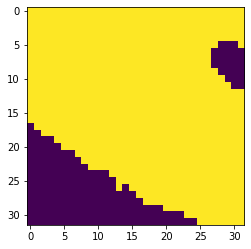

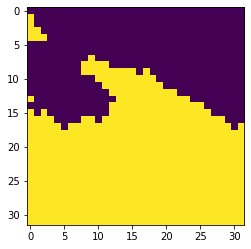

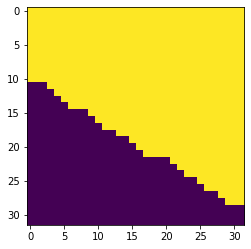

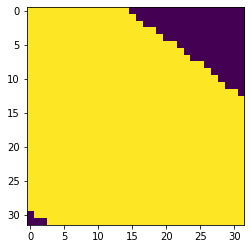

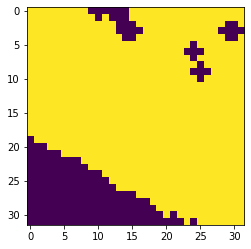

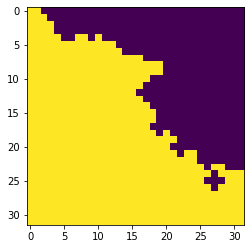

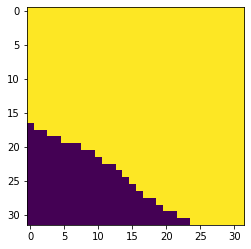

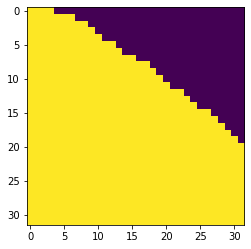

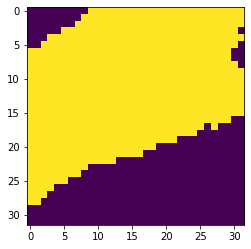

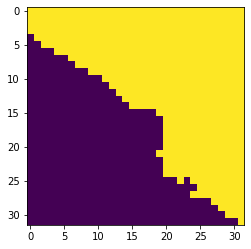

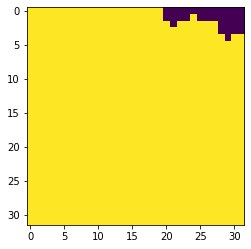

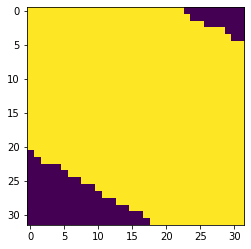

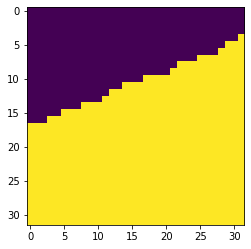

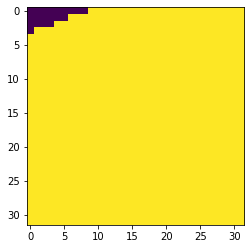

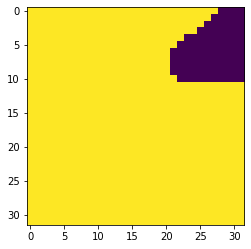

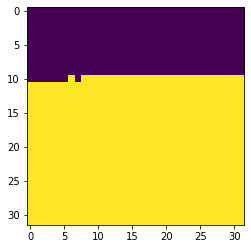

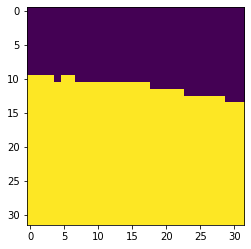

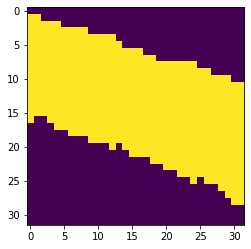

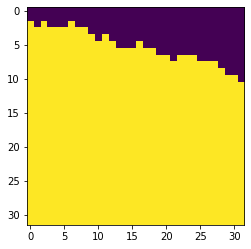

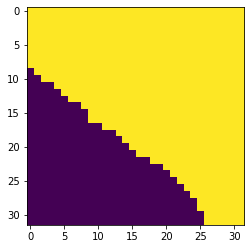

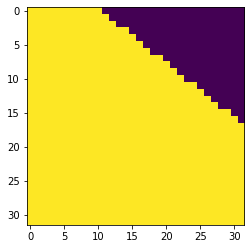

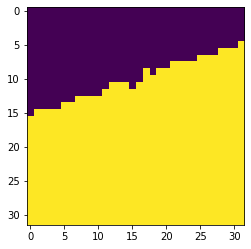

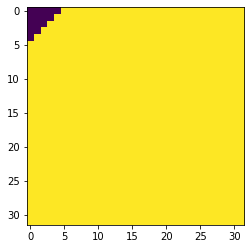

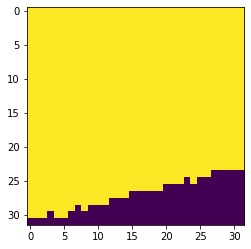

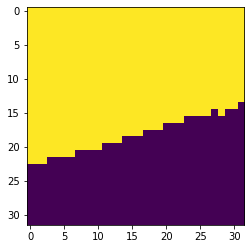

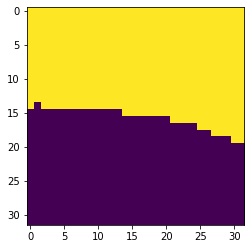

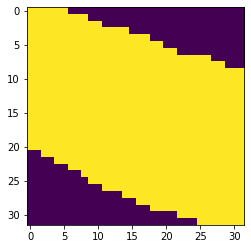

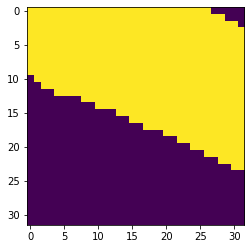

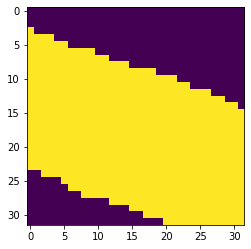

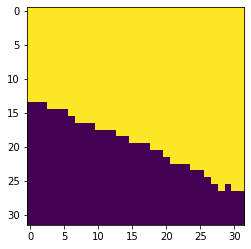

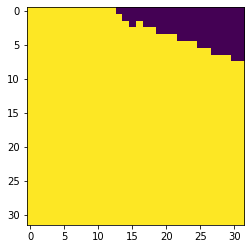

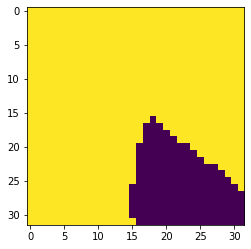

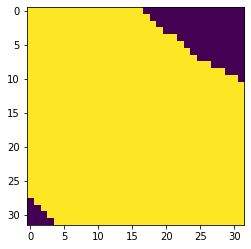

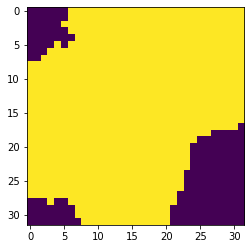

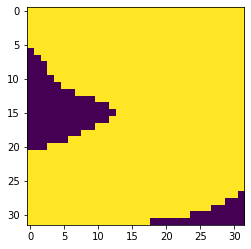

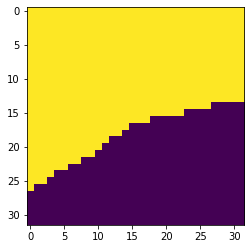

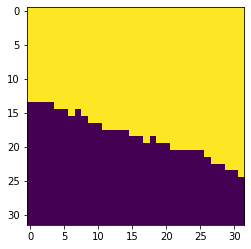

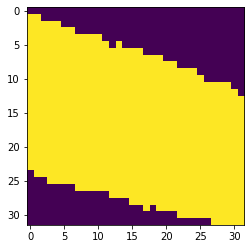

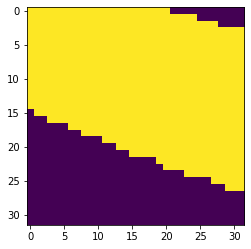

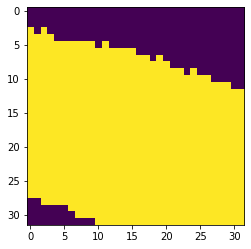

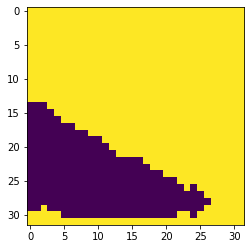

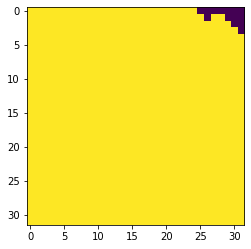

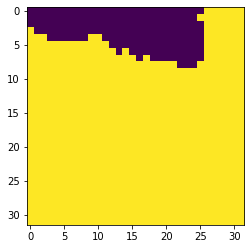

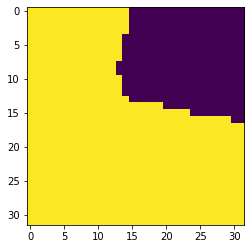

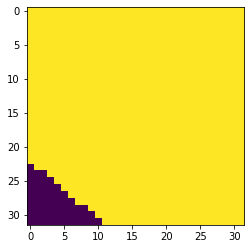

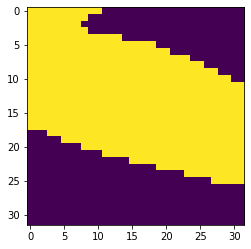

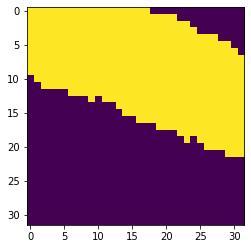

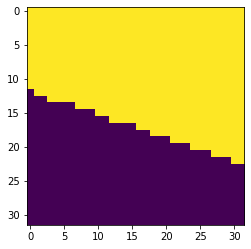

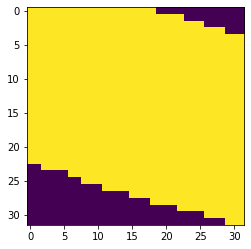

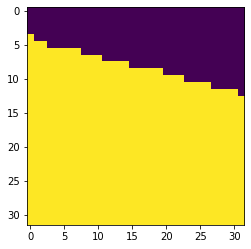

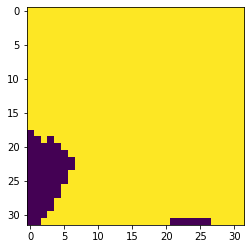

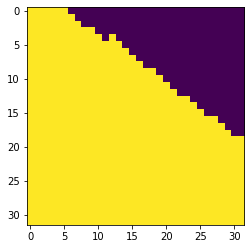

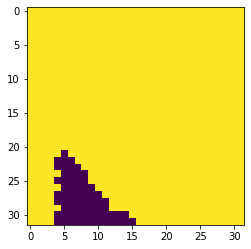

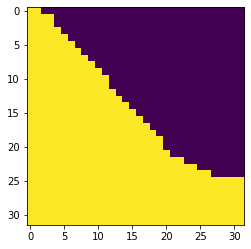

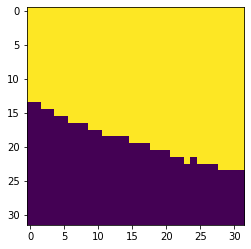

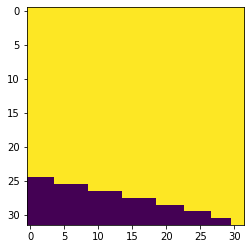

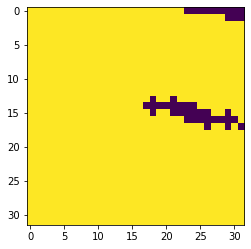

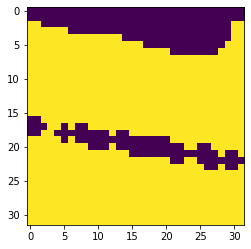

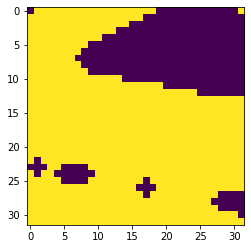

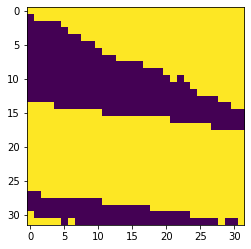

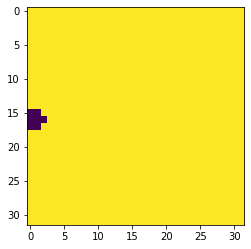

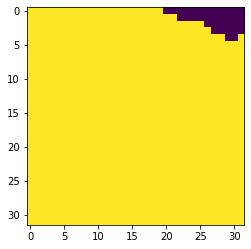

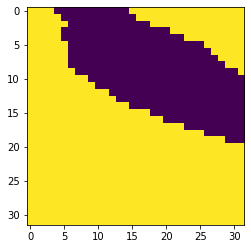

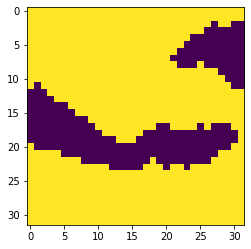

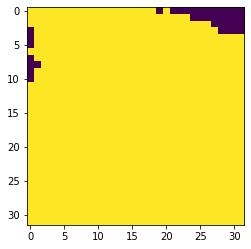

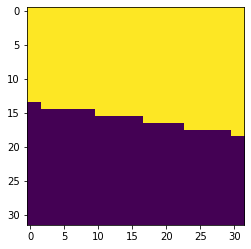

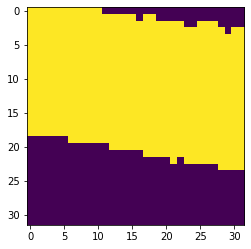

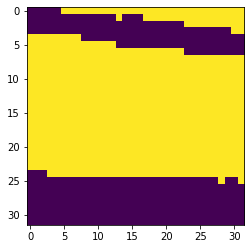

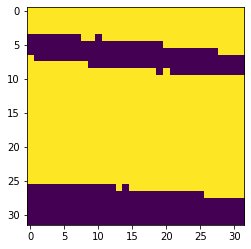

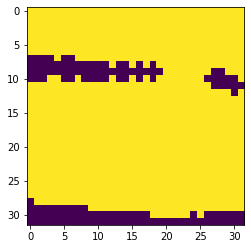

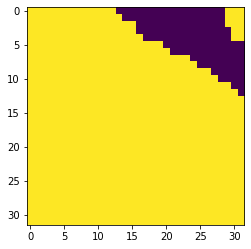

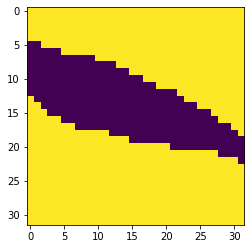

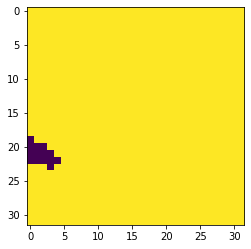

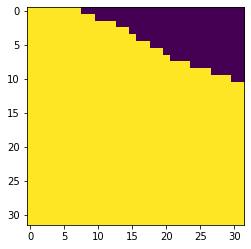

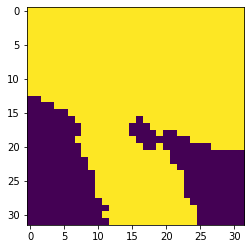

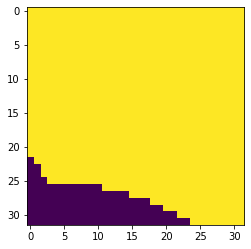

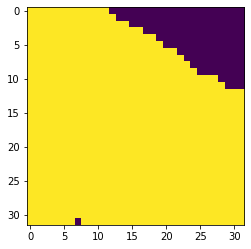

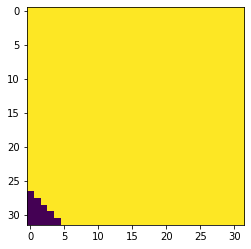

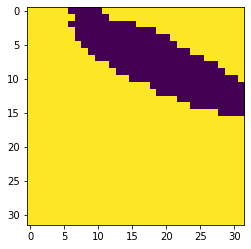

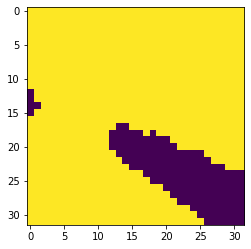

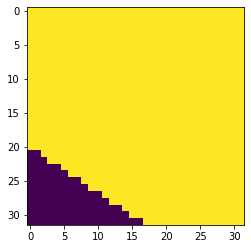

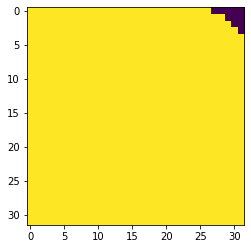

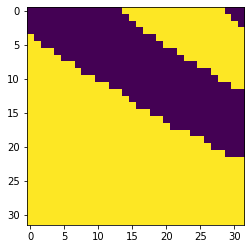

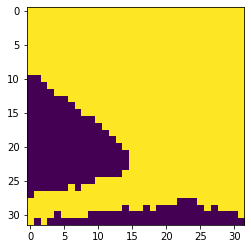

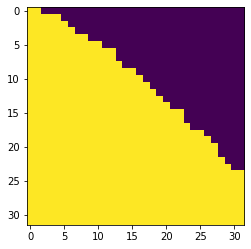

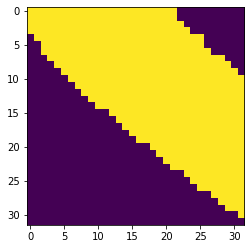

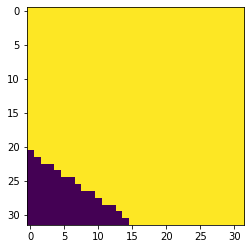

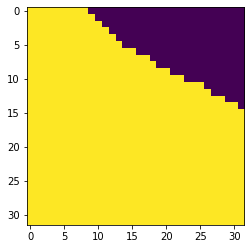

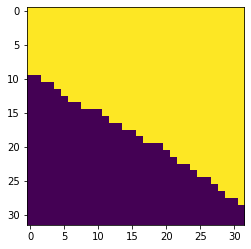

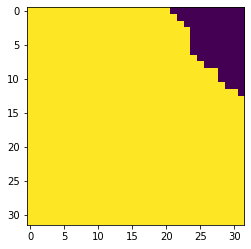

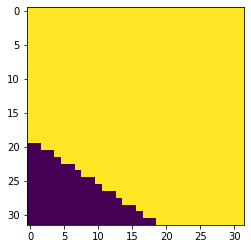

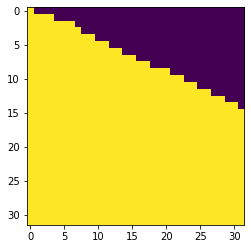

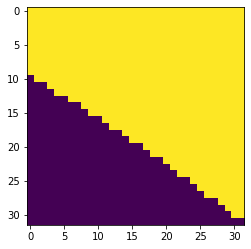

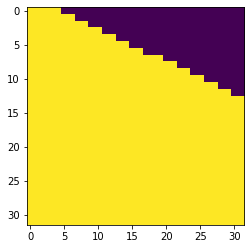

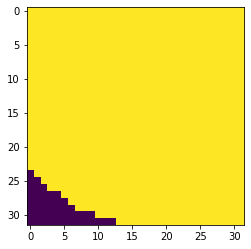

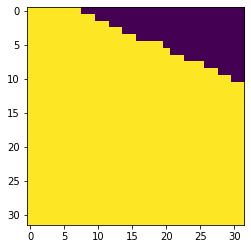

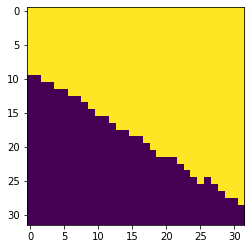

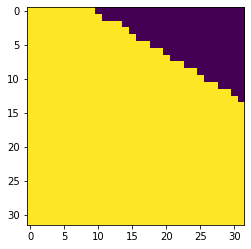

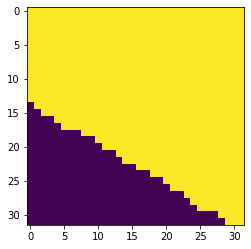

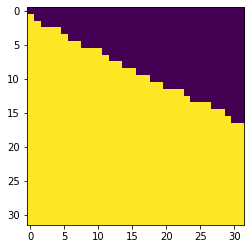

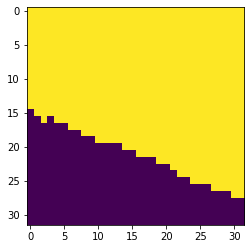

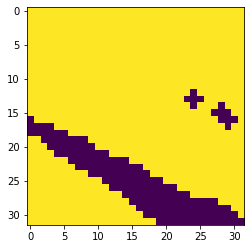

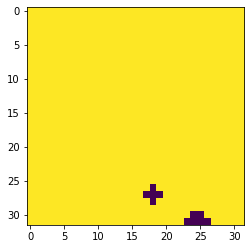

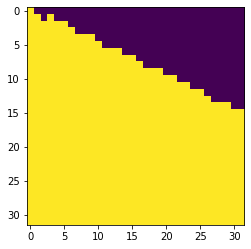

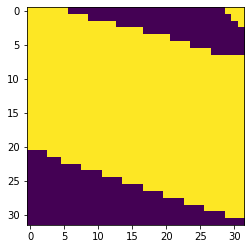

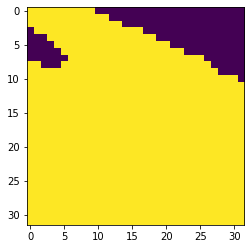

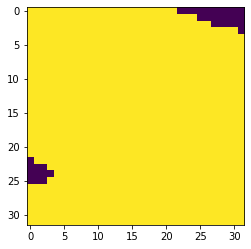

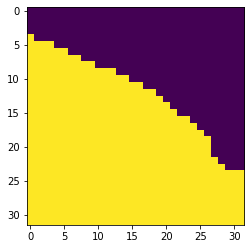

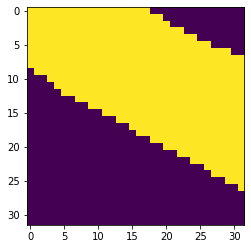

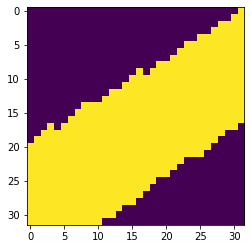

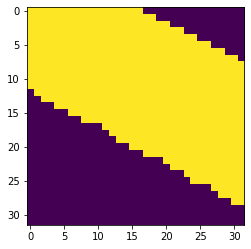

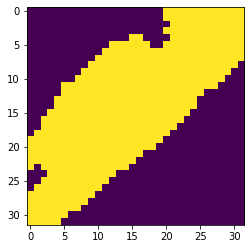

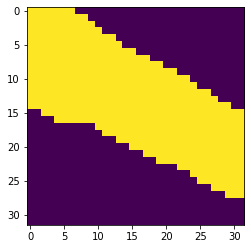

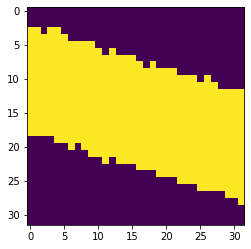

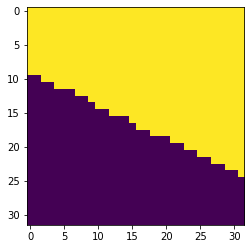

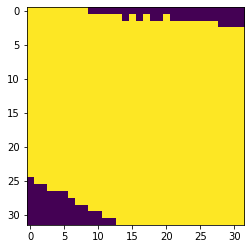

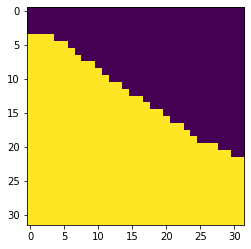

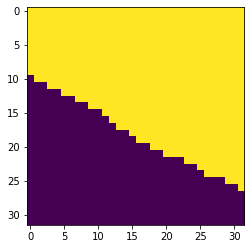

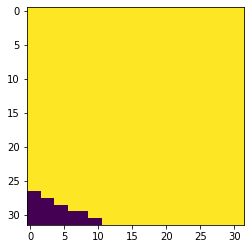

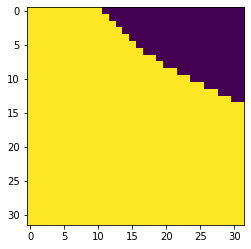

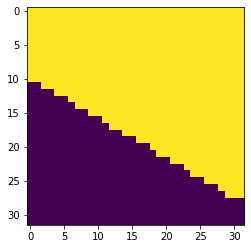

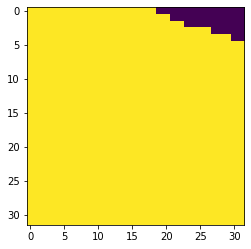

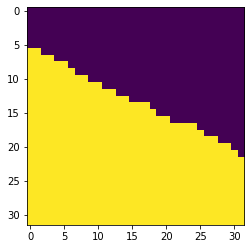

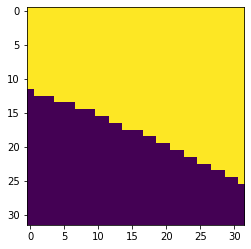

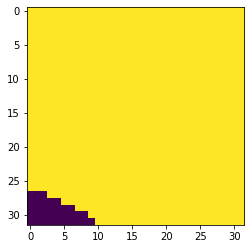

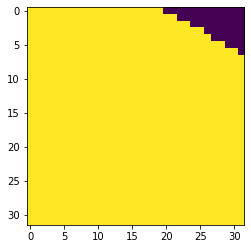

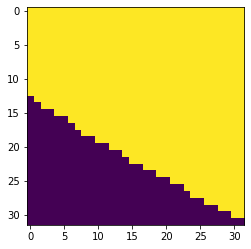

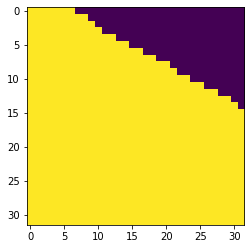

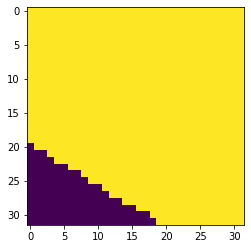

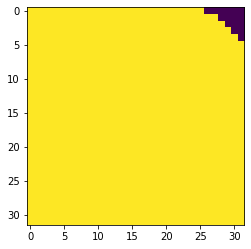

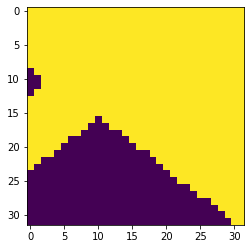

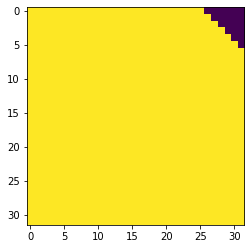

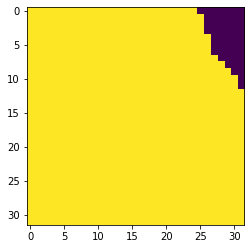

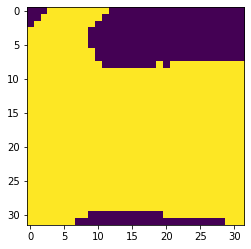

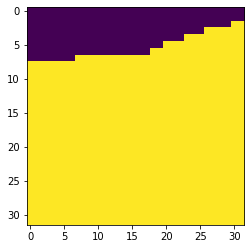

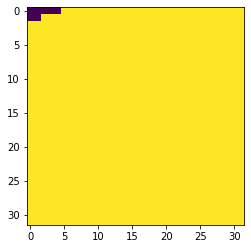

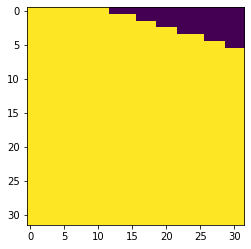

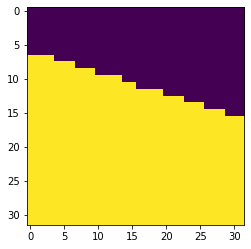

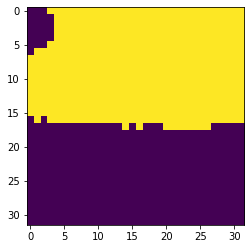

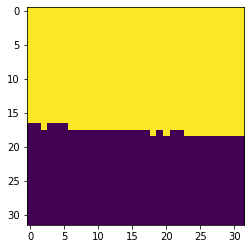

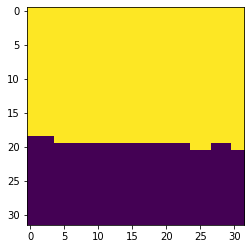

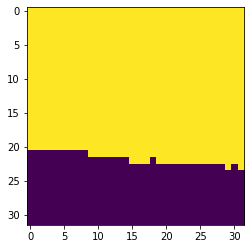

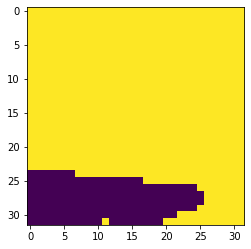

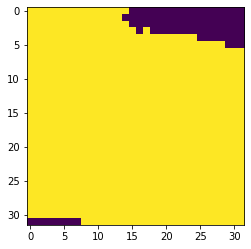

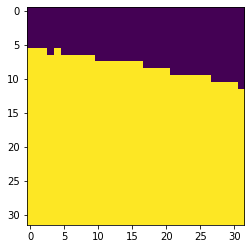

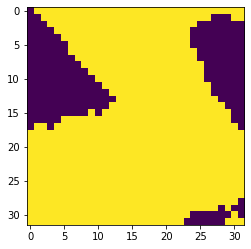

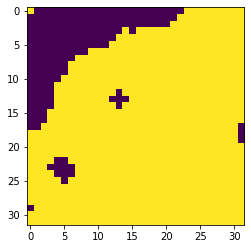

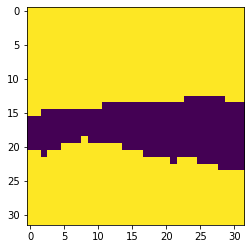

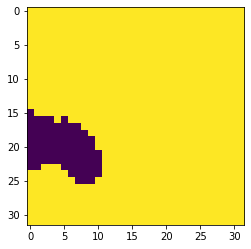

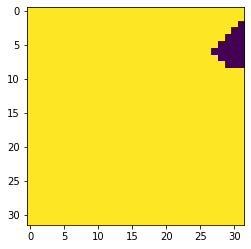

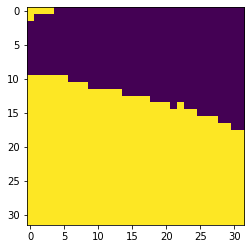

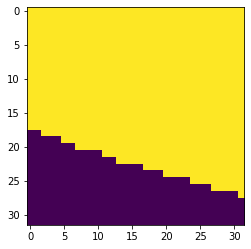

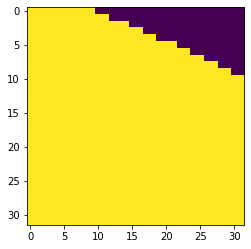

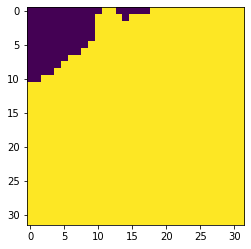

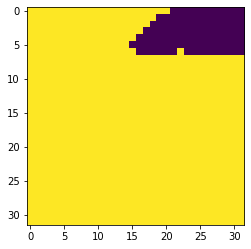

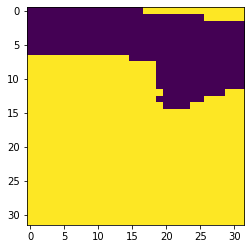

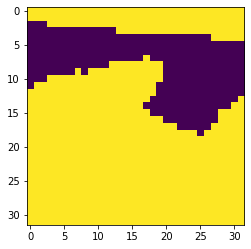

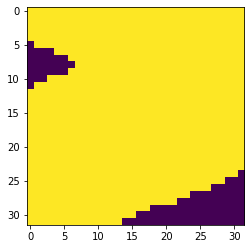

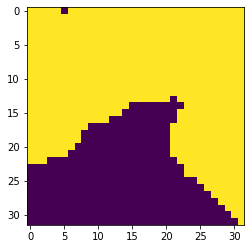

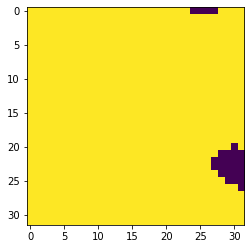

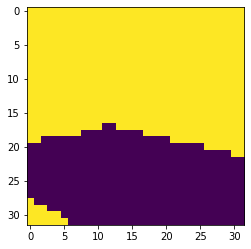

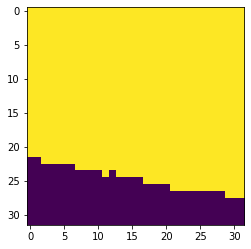

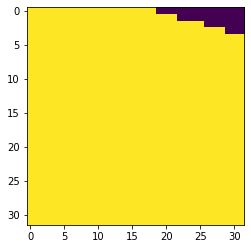

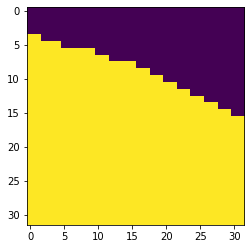

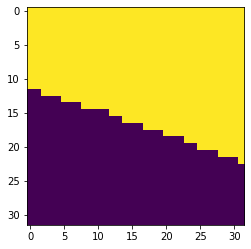

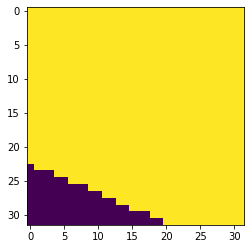

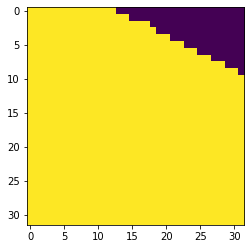

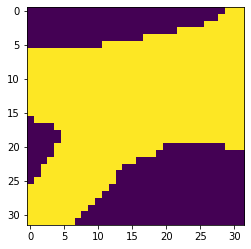

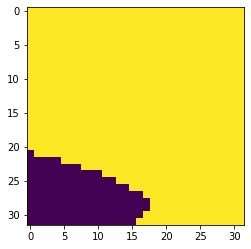

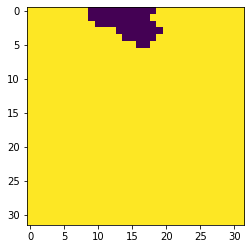

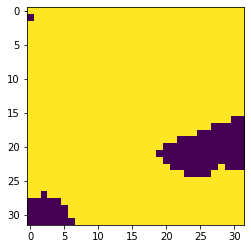

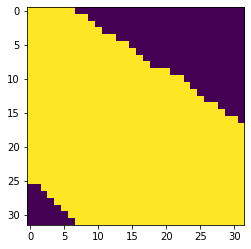

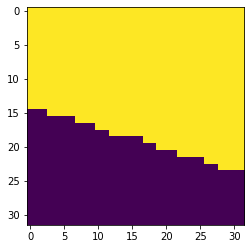

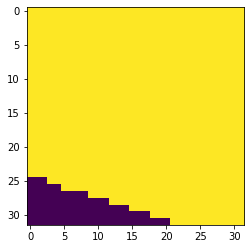

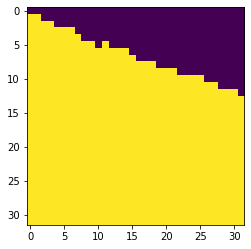

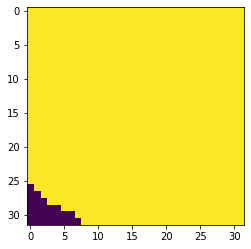

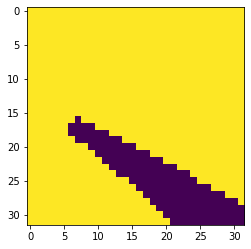

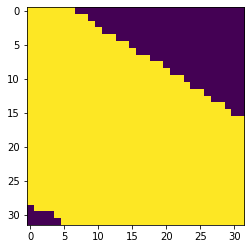

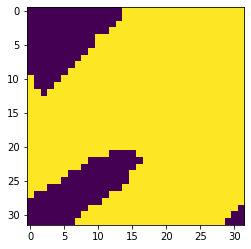

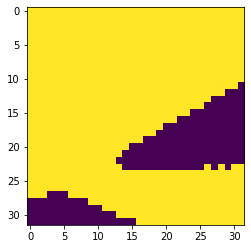

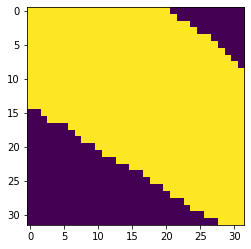

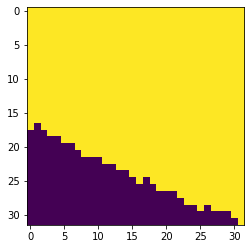

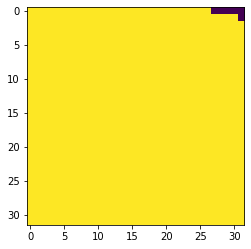

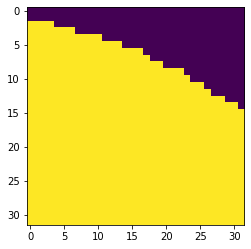

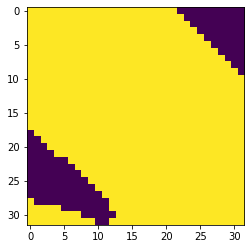

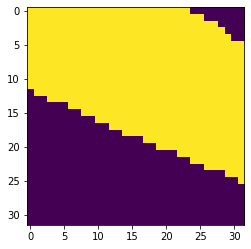

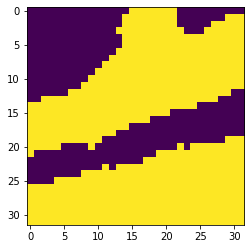

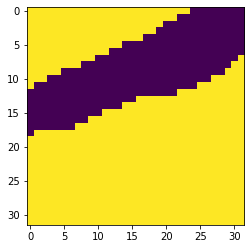

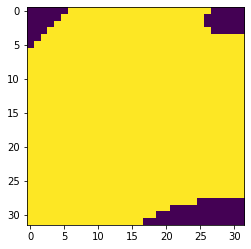

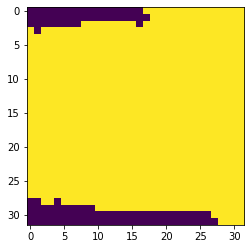

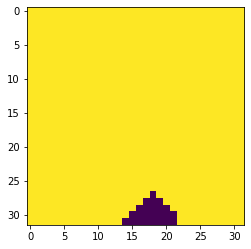

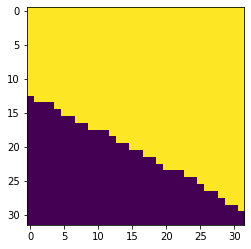

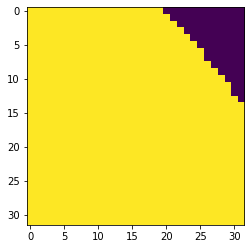

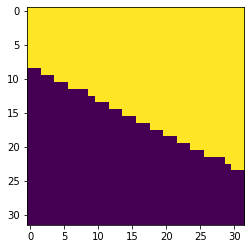

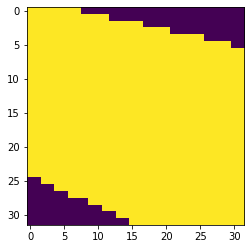

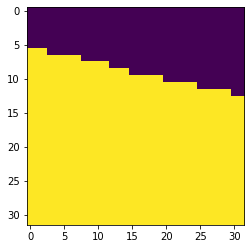

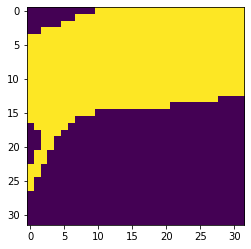

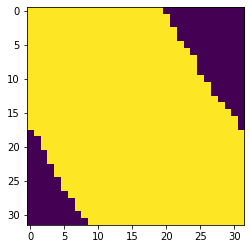

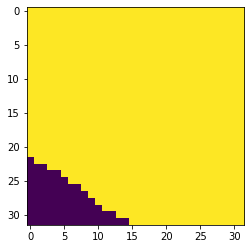

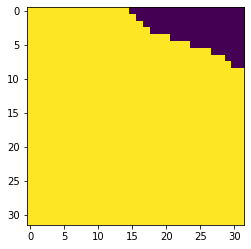

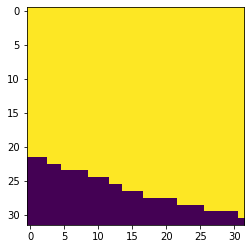

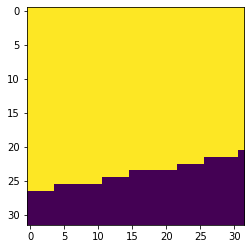

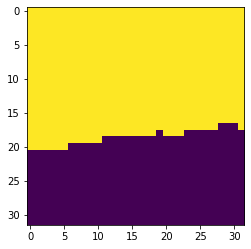

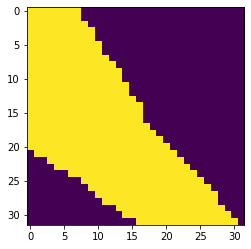

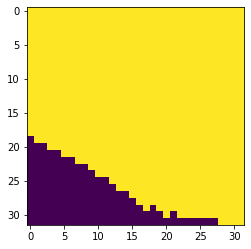

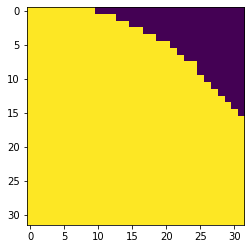

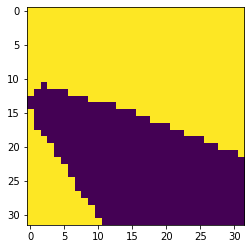

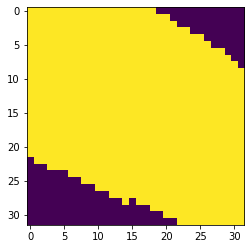

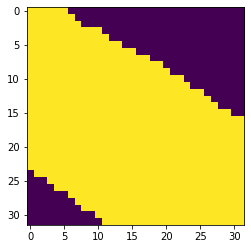

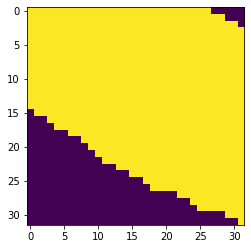

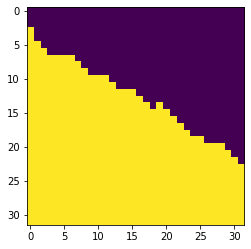

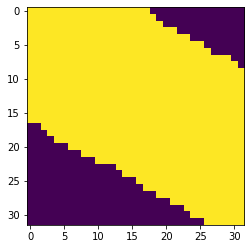

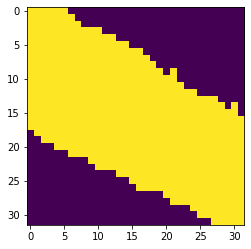

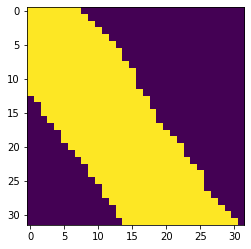

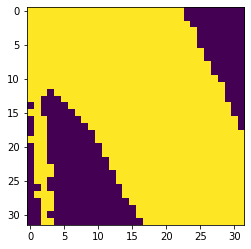

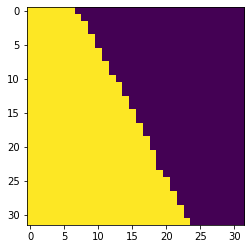

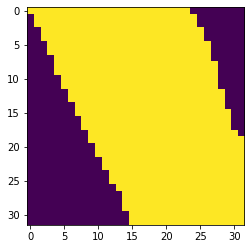

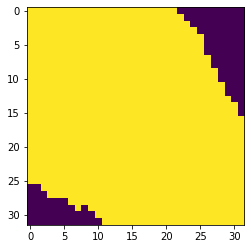

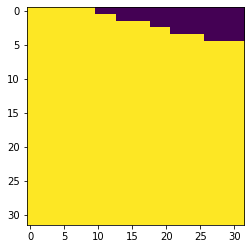

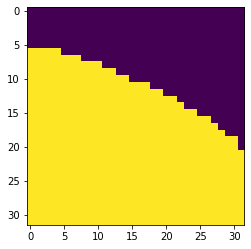

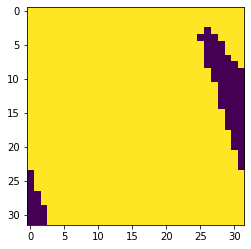

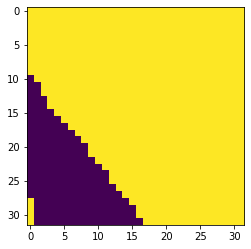

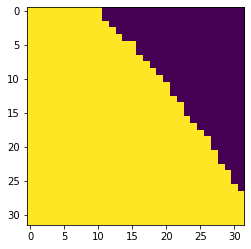

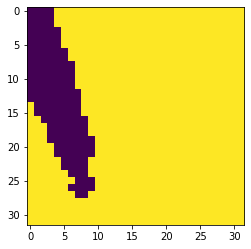

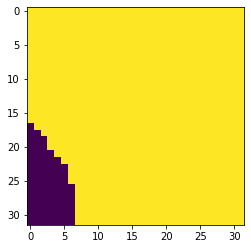

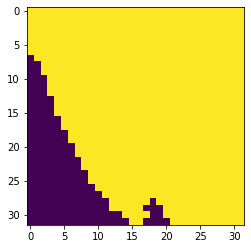

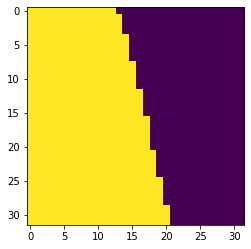

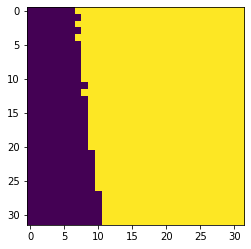

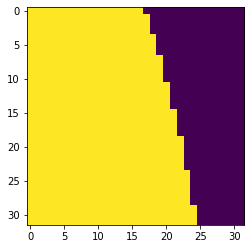

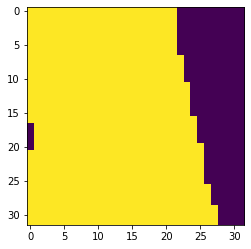

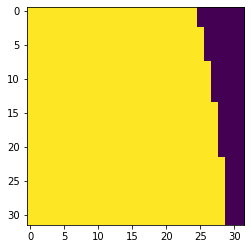

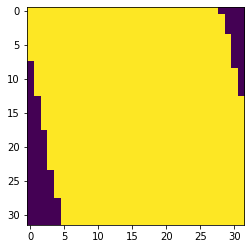

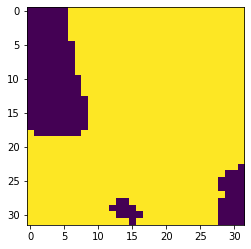

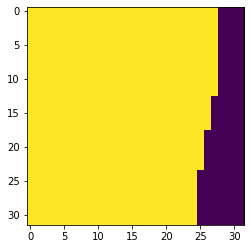

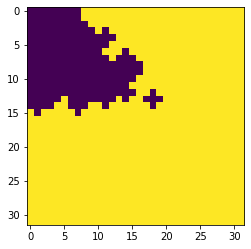

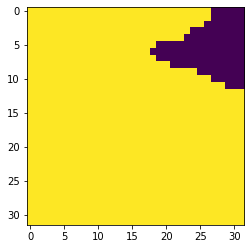

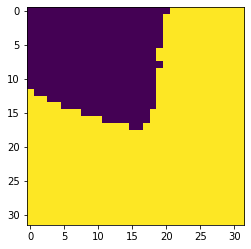

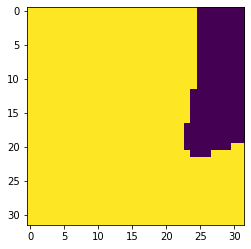

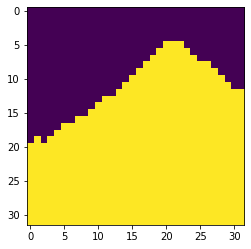

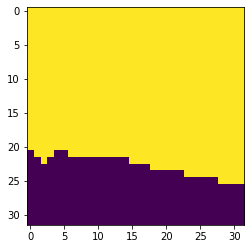

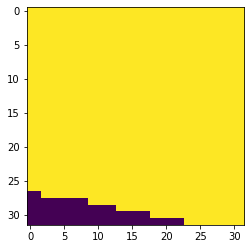

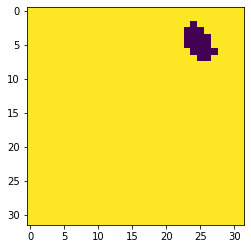

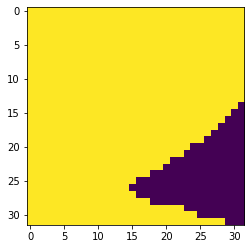

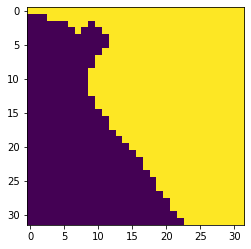

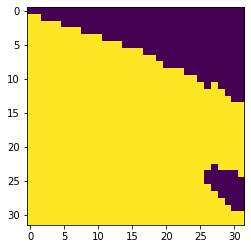

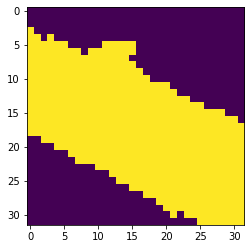

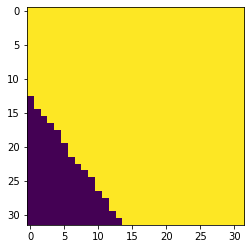

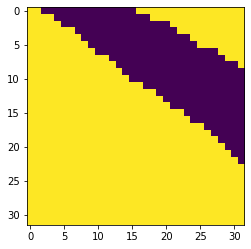

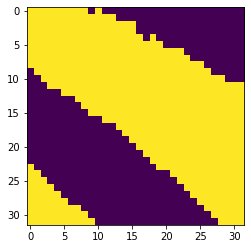

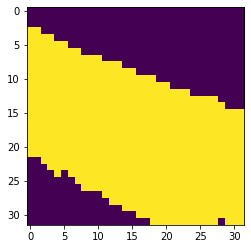

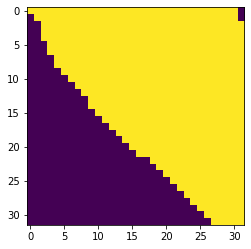

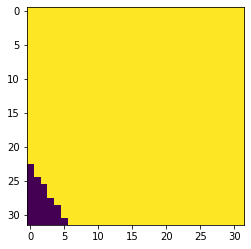

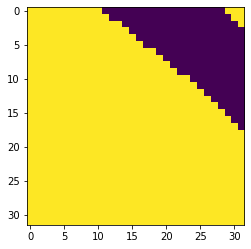

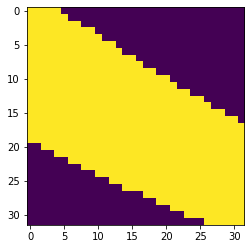

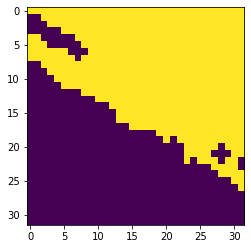

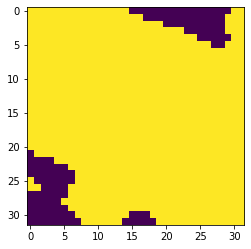

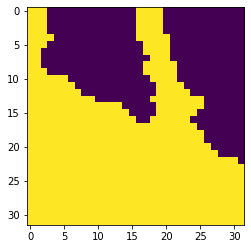

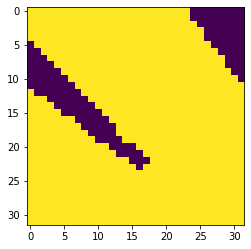

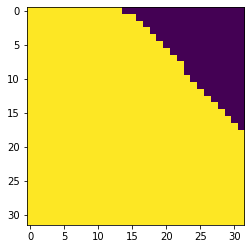

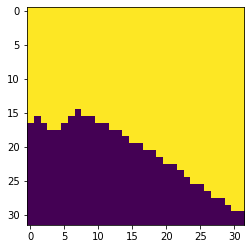

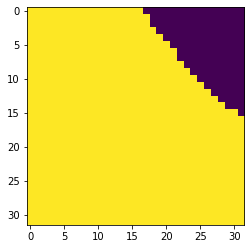

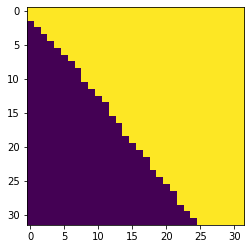

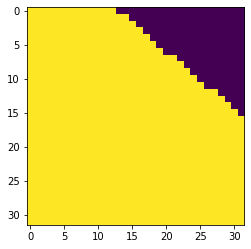

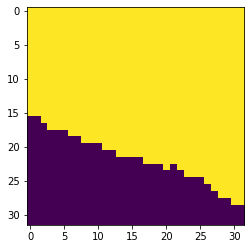

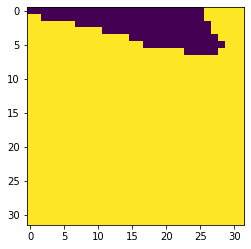

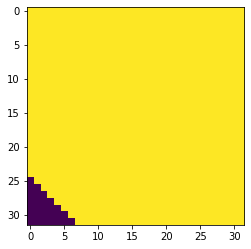

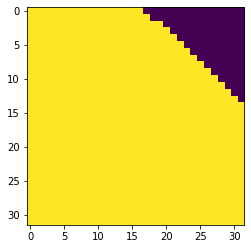

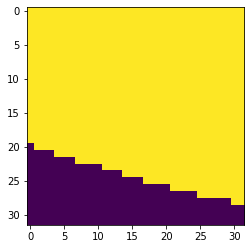

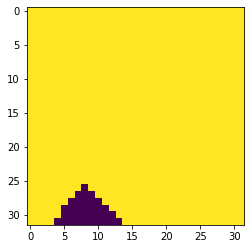

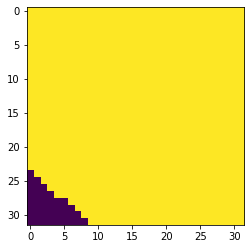

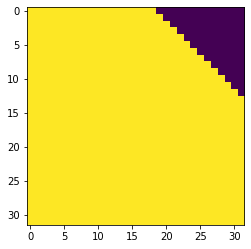

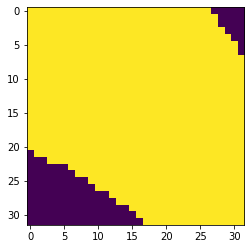

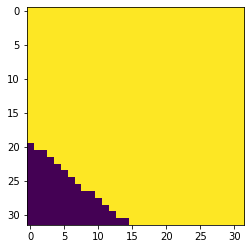

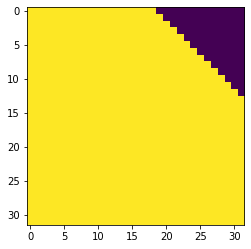

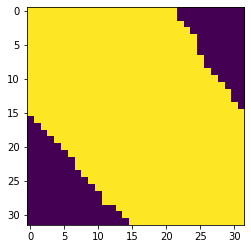

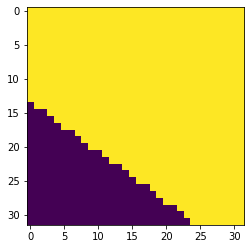

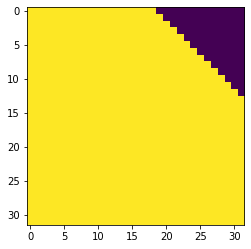

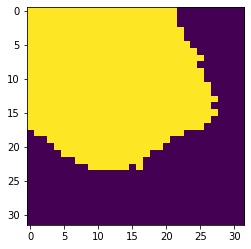

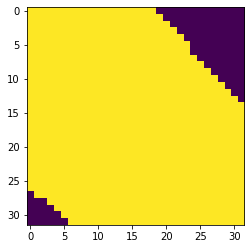

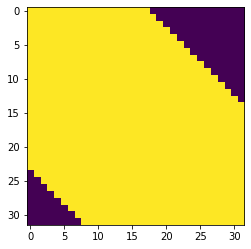

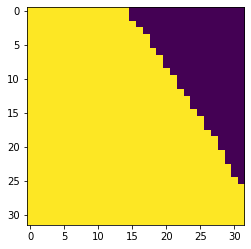

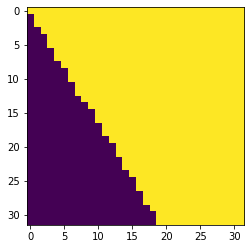

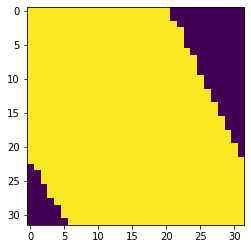

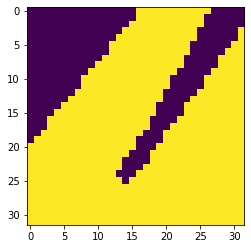

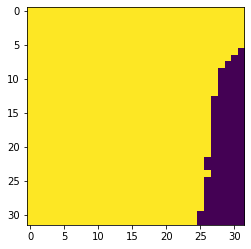

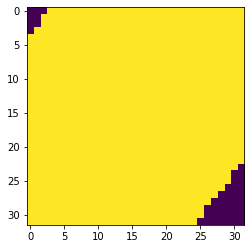

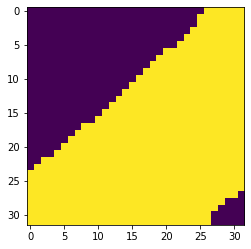

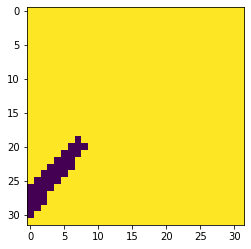

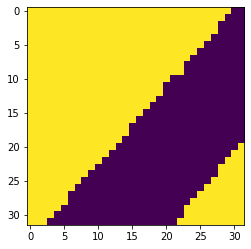

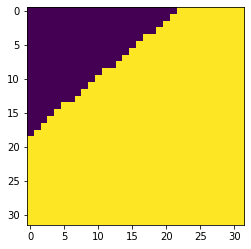

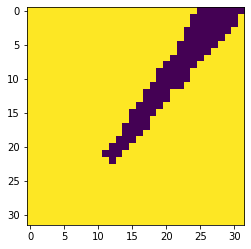

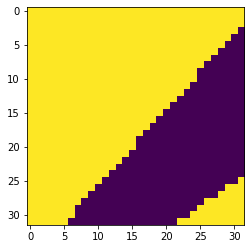

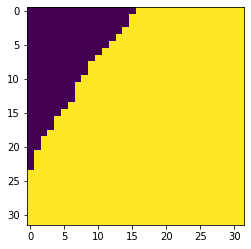

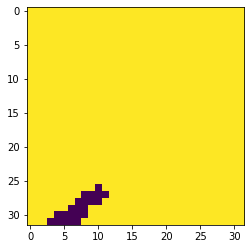

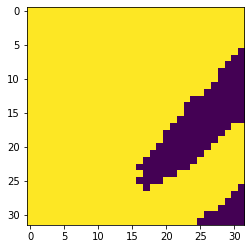

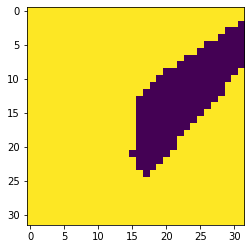

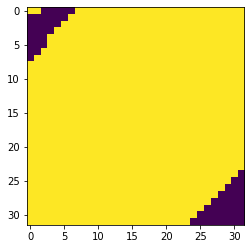

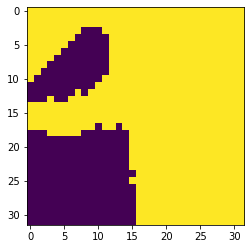

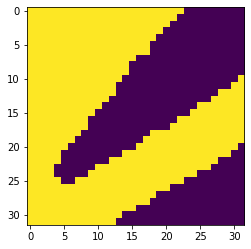

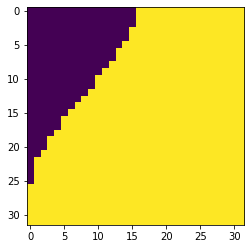

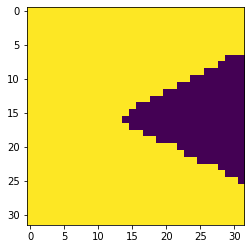

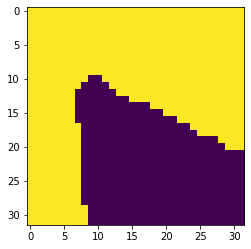

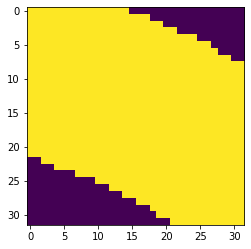

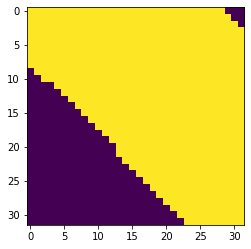

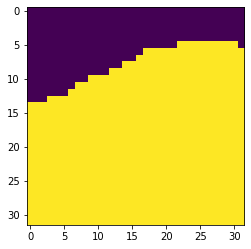

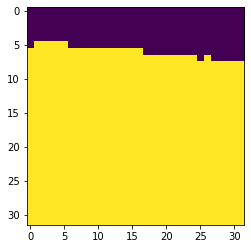

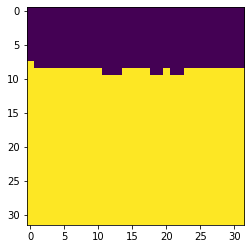

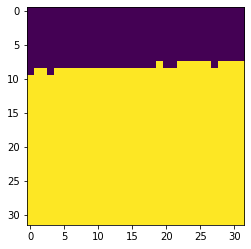

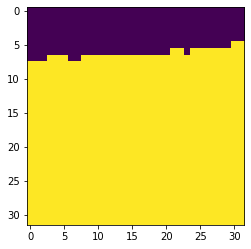

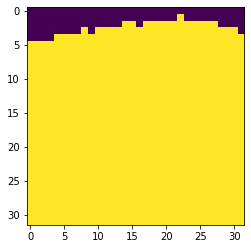

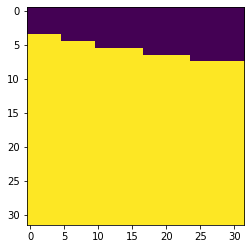

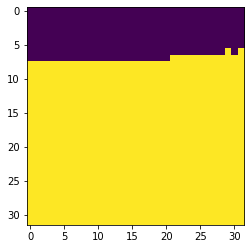

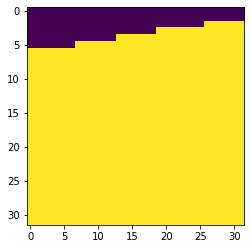

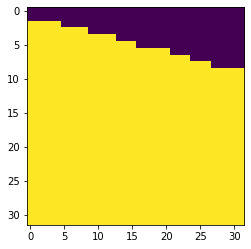

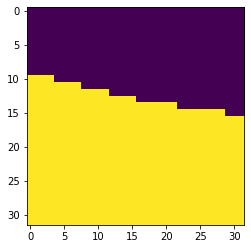

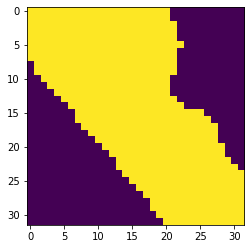

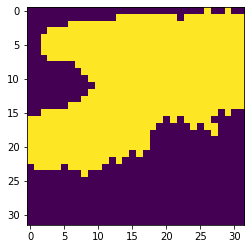

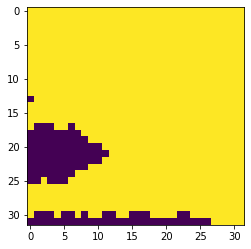

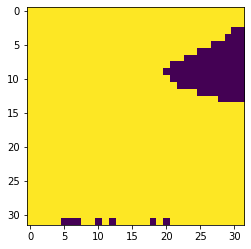

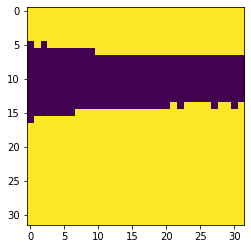

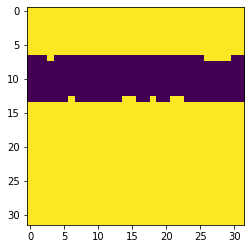

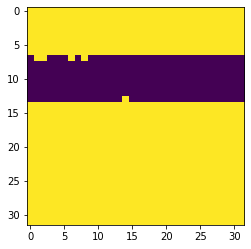

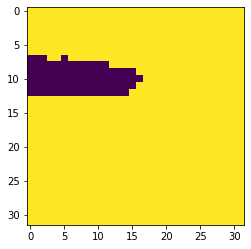

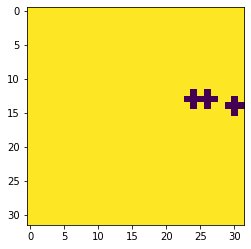

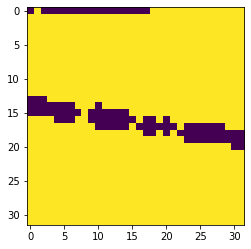

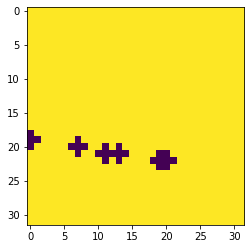

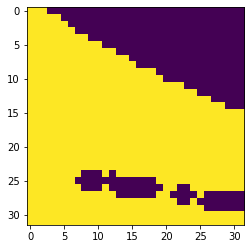

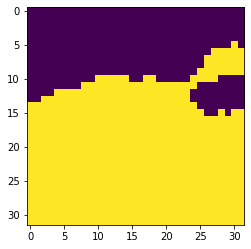

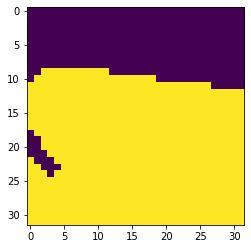

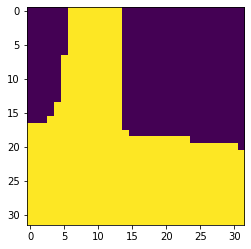

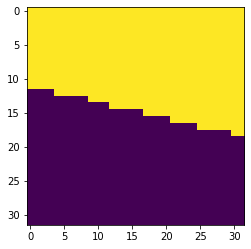

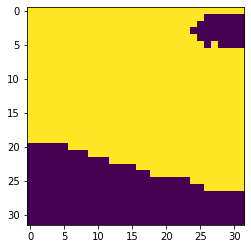

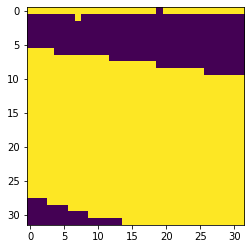

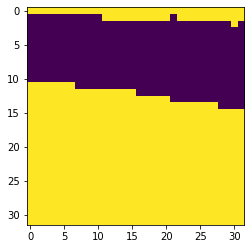

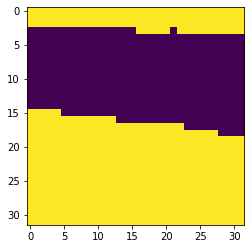

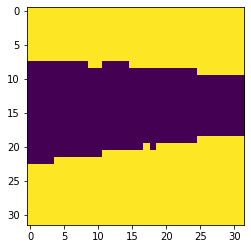

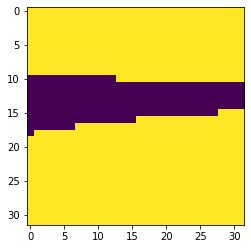

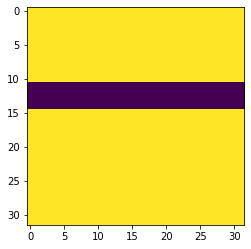

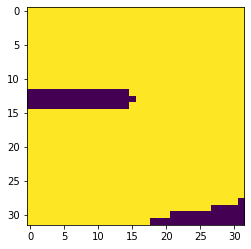

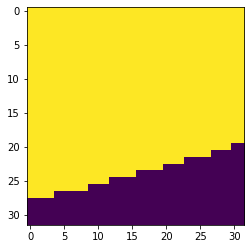

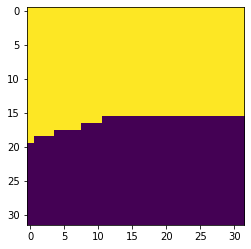

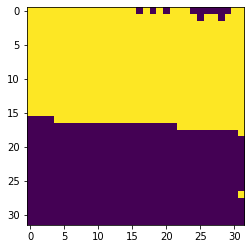

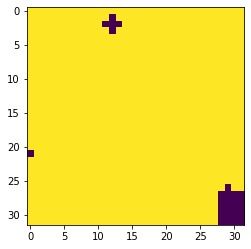

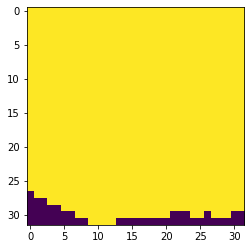

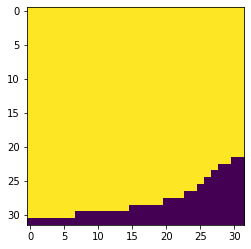

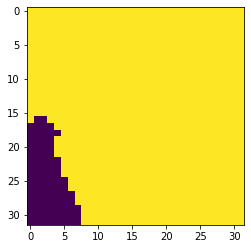

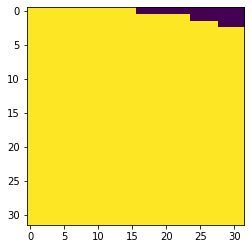

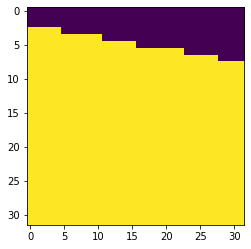

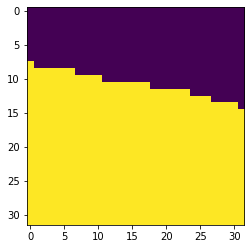

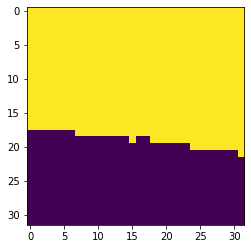

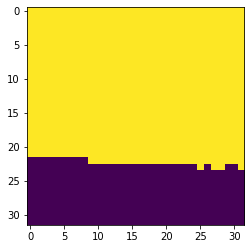

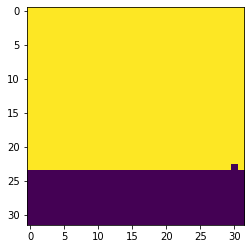

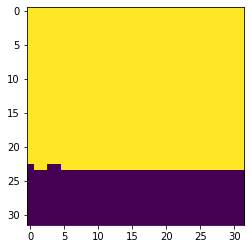

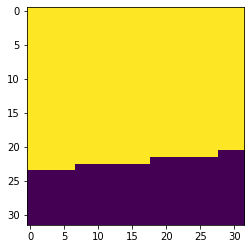

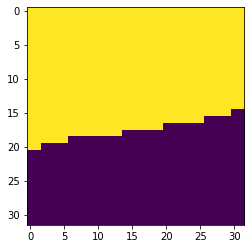

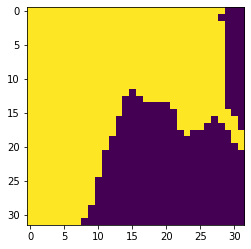

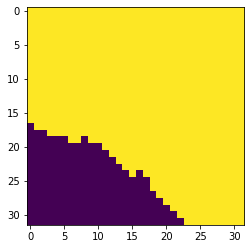

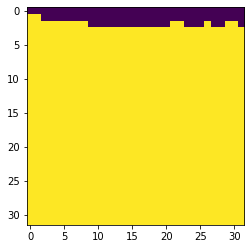

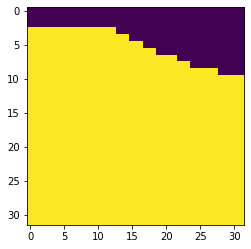

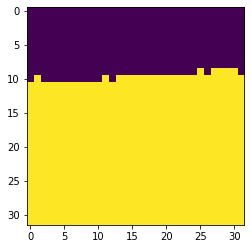

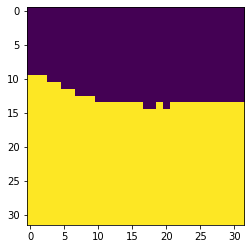

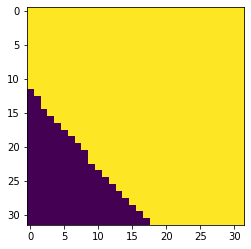

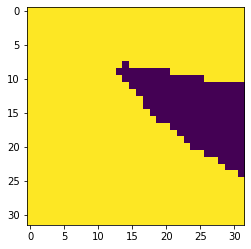

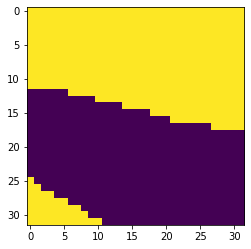

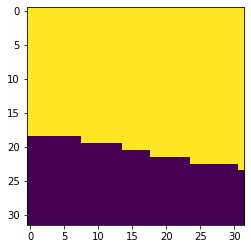

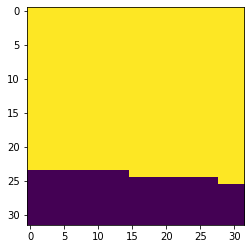

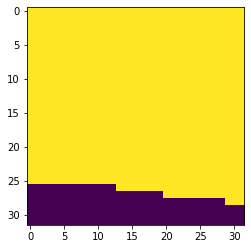

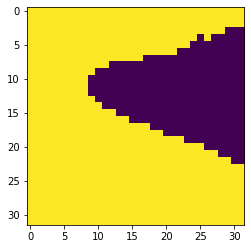

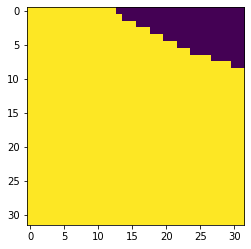

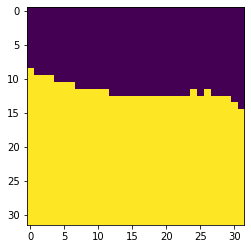

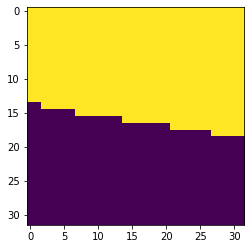

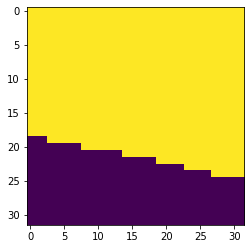

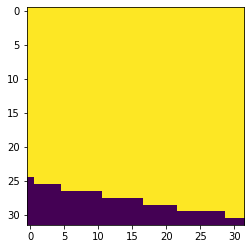

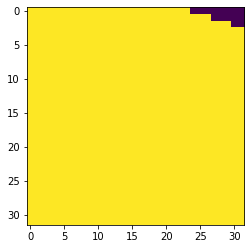

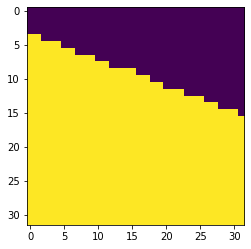

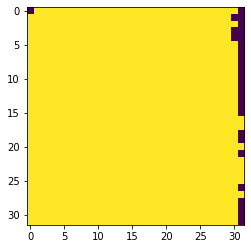

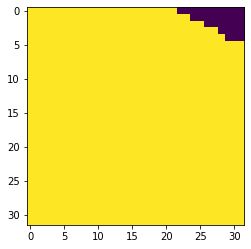

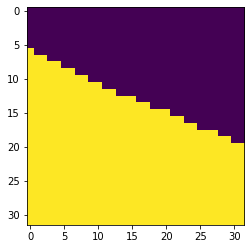

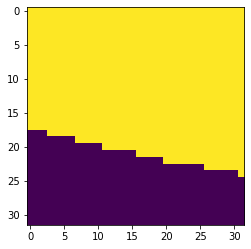

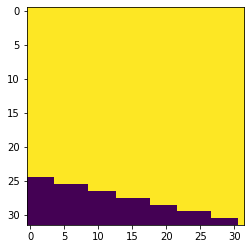

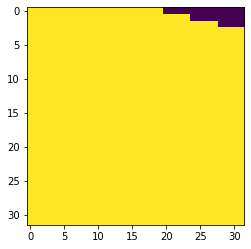

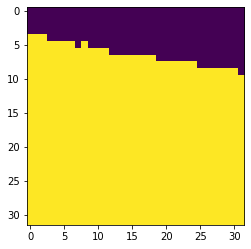

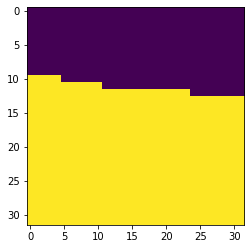

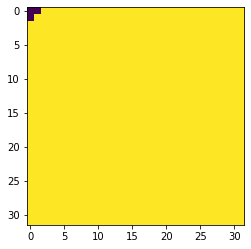

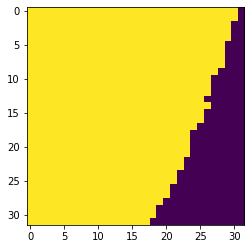

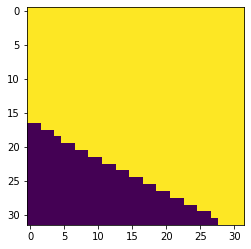

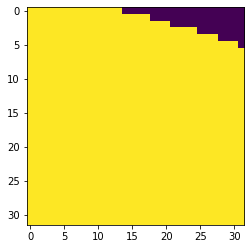

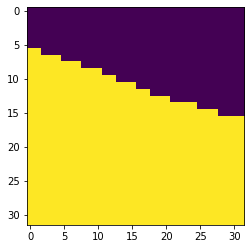

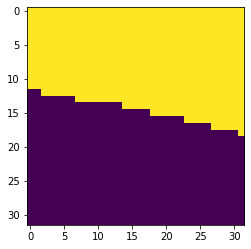

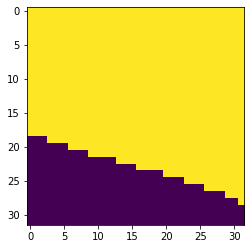

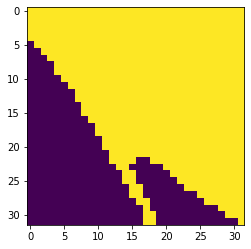

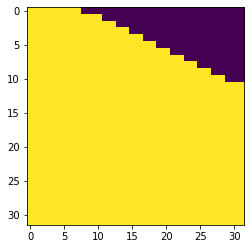

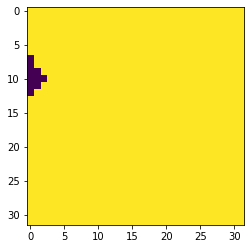

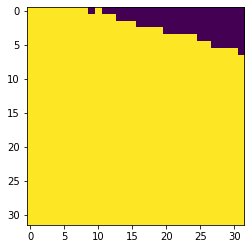

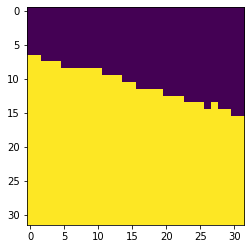

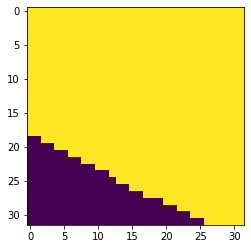

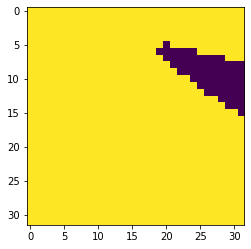

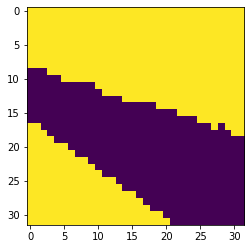

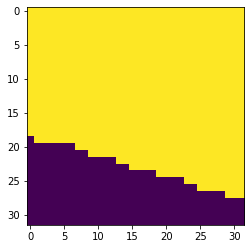

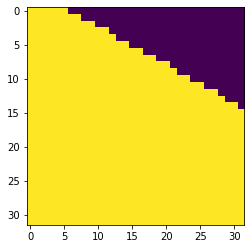

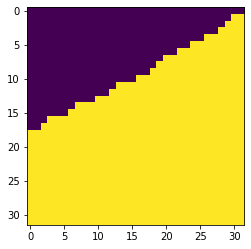

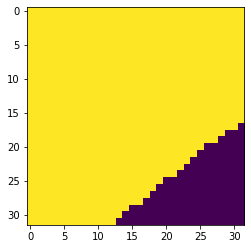

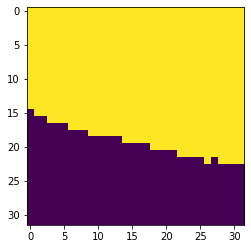

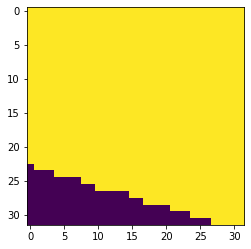

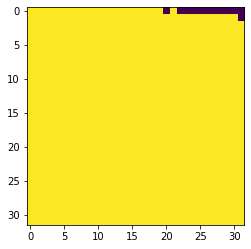

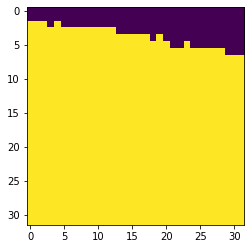

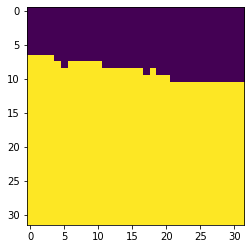

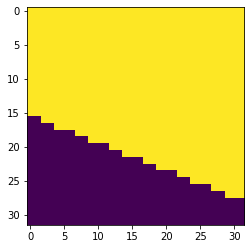

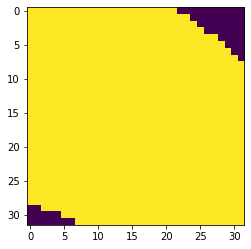

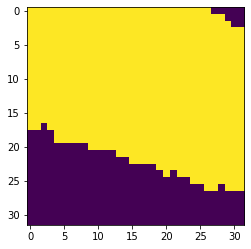

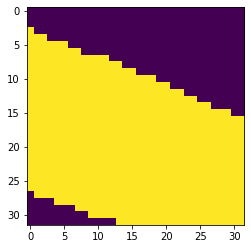

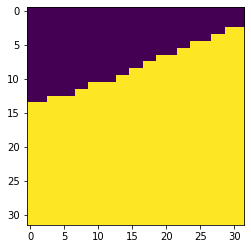

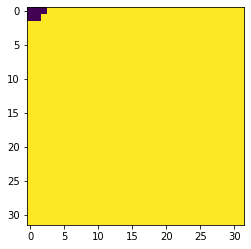

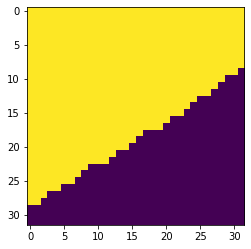

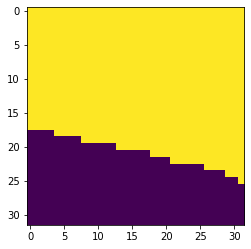

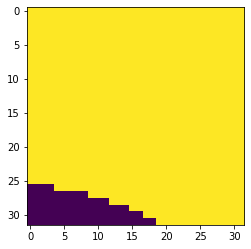

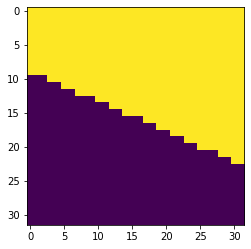

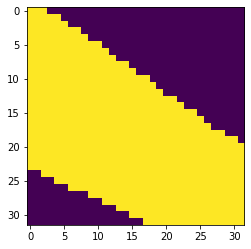

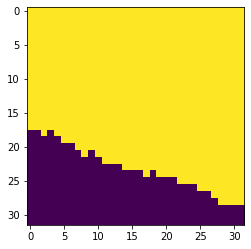

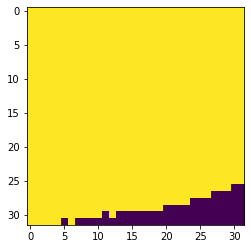

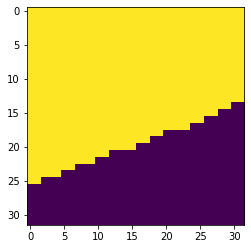

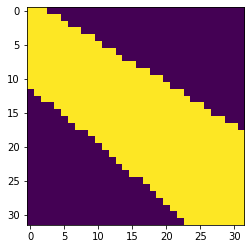

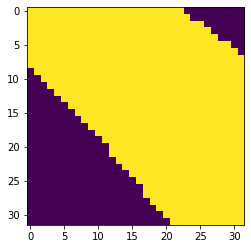

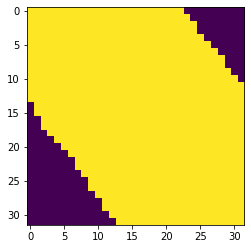

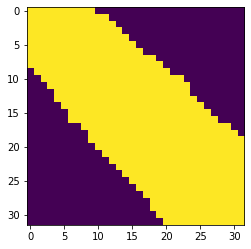

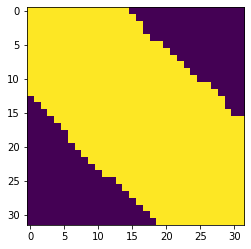

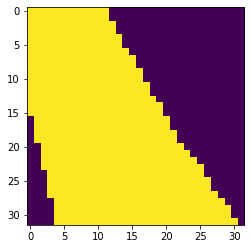

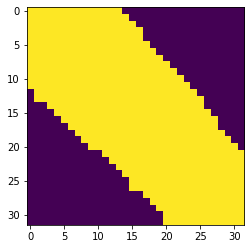

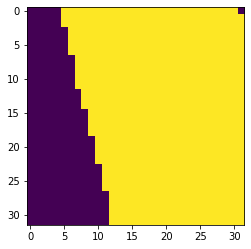

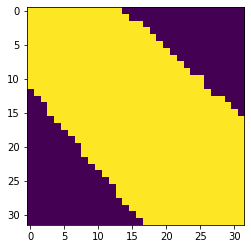

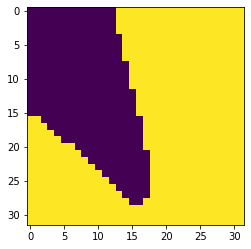

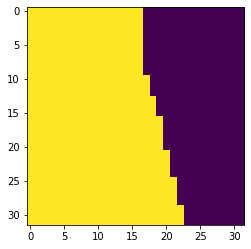

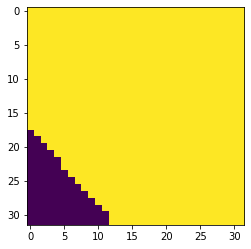

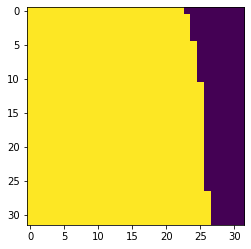

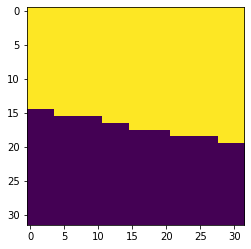

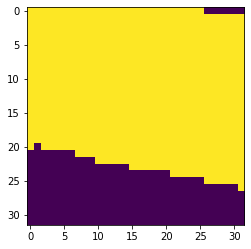

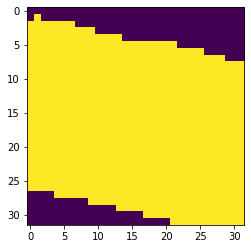

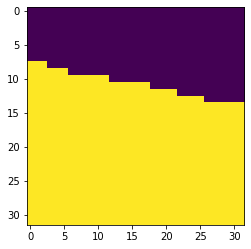

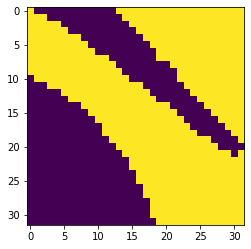

Error in callback <function flush_figures at 0x7feccd8f3040> (for post_execute):


KeyboardInterrupt: 

In [16]:
#Plot some patches.
count=0
for sugarcane in sugarcane_img_list:
    print(sugarcane.img_path)
    label_img=np.array(Image.open(sugarcane.img_path)).astype(np.int32)[:,:,0]
    for t in sugarcane.coordinate_list:
        patch=label_img[t[0]:t[0]+WINDOW_SIZE,t[1]:t[1]+WINDOW_SIZE]
        plt.figure()
        plt.imshow(patch)
    count+=1
    if count==10:
        break

In [12]:
save_data(sugarcane_img_list)          